# 03 - Model Training: Isolation Forest vs XGBoost

本 Notebook 聚焦於：
- 無監督學習：Isolation Forest（不需要標籤）
- 監督學習：XGBoost（使用標籤）
- 比較兩種方法的差異與優勢
- 產出關鍵視覺化圖表用於 Demo


## 1. 環境設定與資料載入


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 設定專案路徑
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == "notebooks":
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / "data" / "processed"
FEATURES_PATH = DATA_DIR / "features.parquet"

# 確保 doc 目錄存在
DOC_DIR = PROJECT_ROOT / "doc"
DOC_DIR.mkdir(exist_ok=True)

# 設定繪圖風格（使用 seaborn 的設定，更相容）
sns.set_style("darkgrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
# plt.rcParams['font.sans-serif'] = ['Arial'] # 英文
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] # 中文
warnings.filterwarnings('ignore')

print("✅ 環境設定完成")

✅ 環境設定完成


In [19]:
print("載入特徵資料...")
df = pd.read_parquet(FEATURES_PATH)

print(f"✅ 資料載入完成")
print(f"   資料筆數: {len(df):,}")
print(f"   特徵欄位數: {len(df.columns)}")
print(f"\n特徵欄位:")
print(df.columns.tolist())

# 檢查標籤分布
if 'label' in df.columns:
    print(f"\n標籤分布:")
    print(df['label'].value_counts().sort_index())
    print(f"\n異常比例(Botnet): {df['label'].sum() / len(df) * 100:.2f}%")


載入特徵資料...
✅ 資料載入完成
   資料筆數: 1,650,333
   特徵欄位數: 16

特徵欄位:
['src_ip', 'time_window', 'flow_count', 'total_bytes', 'total_packets', 'avg_duration', 'min_duration', 'max_duration', 'label', 'dst_ip_diversity', 'dst_port_diversity', 'protocol_diversity', 'bytes_per_flow', 'packets_per_flow', 'port_entropy', 'protocol_entropy']

標籤分布:
label
0    1640956
1       9377
Name: count, dtype: int64

異常比例(Botnet): 0.57%


## 2. 準備特徵與標籤


In [20]:
## 2. 準備特徵與標籤

print("=" * 60)
print("資料清理與特徵準備")
print("=" * 60)

# 選擇用於訓練的特徵（排除識別欄位和標籤）
feature_columns = [
    'flow_count', 'total_bytes', 'total_packets', 
    'avg_duration', 'min_duration', 'max_duration',
    'dst_ip_diversity', 'dst_port_diversity', 'protocol_diversity',
    'bytes_per_flow', 'packets_per_flow',
    'port_entropy', 'protocol_entropy'
]

# 檢查所有特徵欄位是否存在
missing_features = [col for col in feature_columns if col not in df.columns]
if missing_features:
    print(f"⚠️ 缺少特徵欄位: {missing_features}")
    feature_columns = [col for col in feature_columns if col in df.columns]

print(f"\n✅ 使用 {len(feature_columns)} 個特徵進行訓練")
print(f"特徵列表: {feature_columns}")

# 資料清理：處理無限值 (inf) 與缺失值
print("\n🧹 正在清理資料 (處理 Infinite/Null)...")
initial_rows = len(df)

# 檢查無限值
numeric_cols = df[feature_columns].select_dtypes(include=[np.number]).columns
inf_counts = {}
for col in numeric_cols:
    inf_count = np.isinf(df[col]).sum()
    if inf_count > 0:
        inf_counts[col] = inf_count

if inf_counts:
    print(f"   發現無限值:")
    for col, count in inf_counts.items():
        print(f"     {col}: {count:,} 個")
    # 將 inf 替換為 NaN（使用字典形式，避免版本問題）
    df.replace({np.inf: np.nan, -np.inf: np.nan}, inplace=True)
    print("   ✅ 無限值已轉換為 NaN")
else:
    print("   ✅ 未發現無限值")

# 檢查缺失值
nan_counts = df[feature_columns].isnull().sum()
total_nans = nan_counts.sum()
if total_nans > 0:
    print(f"\n   發現缺失值: {total_nans:,} 個")
    for col in feature_columns:
        if nan_counts[col] > 0:
            print(f"     {col}: {nan_counts[col]:,} 個 ({nan_counts[col]/len(df)*100:.2f}%)")
    
    # 用 0 填充缺失值（保留所有資料）
    df[feature_columns] = df[feature_columns].fillna(0)
    print("   ✅ 缺失值已用 0 填充")
else:
    print("\n   ✅ 未發現缺失值")

# 提取特徵和標籤
X = df[feature_columns].copy()
y = df['label'].copy() if 'label' in df.columns else None

# 最終資料統計
print(f"\n✅ 資料準備完成")
print(f"   初始筆數: {initial_rows:,}")
print(f"   最終筆數: {len(df):,}")
print(f"   特徵矩陣形狀: {X.shape}")
if y is not None:
    print(f"   標籤分布: 正常={sum(y==0):,}, 異常={sum(y==1):,}")
print("=" * 60)

資料清理與特徵準備

✅ 使用 13 個特徵進行訓練
特徵列表: ['flow_count', 'total_bytes', 'total_packets', 'avg_duration', 'min_duration', 'max_duration', 'dst_ip_diversity', 'dst_port_diversity', 'protocol_diversity', 'bytes_per_flow', 'packets_per_flow', 'port_entropy', 'protocol_entropy']

🧹 正在清理資料 (處理 Infinite/Null)...
   ✅ 未發現無限值

   ✅ 未發現缺失值

✅ 資料準備完成
   初始筆數: 1,650,333
   最終筆數: 1,650,333
   特徵矩陣形狀: (1650333, 13)
   標籤分布: 正常=1,640,956, 異常=9,377


## 3. Isolation Forest (無監督學習)


In [21]:
print("=" * 60)
print("Isolation Forest (無監督學習)")
print("=" * 60)

# 標準化特徵（Isolation Forest 對尺度敏感）
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 訓練 Isolation Forest（使用預設參數）
print("\n訓練 Isolation Forest...")
# 計算預期異常比例（如果有標籤的話，否則使用預設值）
contamination = 0.05  # contamination: 預期異常比例，設為 0.05 (5%) 略高於實際比例以捕捉邊緣案例
if y is not None:
    contamination = y.sum() / len(y)
    print(f"   使用標籤計算的異常比例: {contamination:.4f}")

iso_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination,
    random_state=42,
    n_jobs=-1
)

# 訓練 (注意：只使用 X，不使用 label y)
iso_forest.fit(X_scaled)

# 預測異常分數（分數越低越可能是異常）
anomaly_scores = iso_forest.score_samples(X_scaled)
# Isolation Forest 的分數是負的，轉換為正數以便理解（分數越高越異常）
anomaly_scores_normalized = -anomaly_scores

print(f"✅ Isolation Forest 訓練完成")
print(f"   異常分數範圍: [{anomaly_scores_normalized.min():.4f}, {anomaly_scores_normalized.max():.4f}]")
print(f"   平均異常分數: {anomaly_scores_normalized.mean():.4f}")

# 如果有標籤，可以查看分數分布
if y is not None:
    print(f"\n異常分數統計（按真實標籤）:")
    print(f"   正常流量 (label=0): 平均分數 = {anomaly_scores_normalized[y==0].mean():.4f}")
    print(f"   異常流量 (label=1): 平均分數 = {anomaly_scores_normalized[y==1].mean():.4f}")


Isolation Forest (無監督學習)

訓練 Isolation Forest...
   使用標籤計算的異常比例: 0.0057
✅ Isolation Forest 訓練完成
   異常分數範圍: [0.3030, 0.8359]
   平均異常分數: 0.3549

異常分數統計（按真實標籤）:
   正常流量 (label=0): 平均分數 = 0.3539
   異常流量 (label=1): 平均分數 = 0.5157


## 4. Isolation Forest 異常分數分布圖


### 4.1 圖表 A -Isolation Forest 原始標籤分佈圖

📊 三張圖：基於原始標籤的分佈分析
✅ 三面板分析圖已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\isolation_forest_3_panels.png


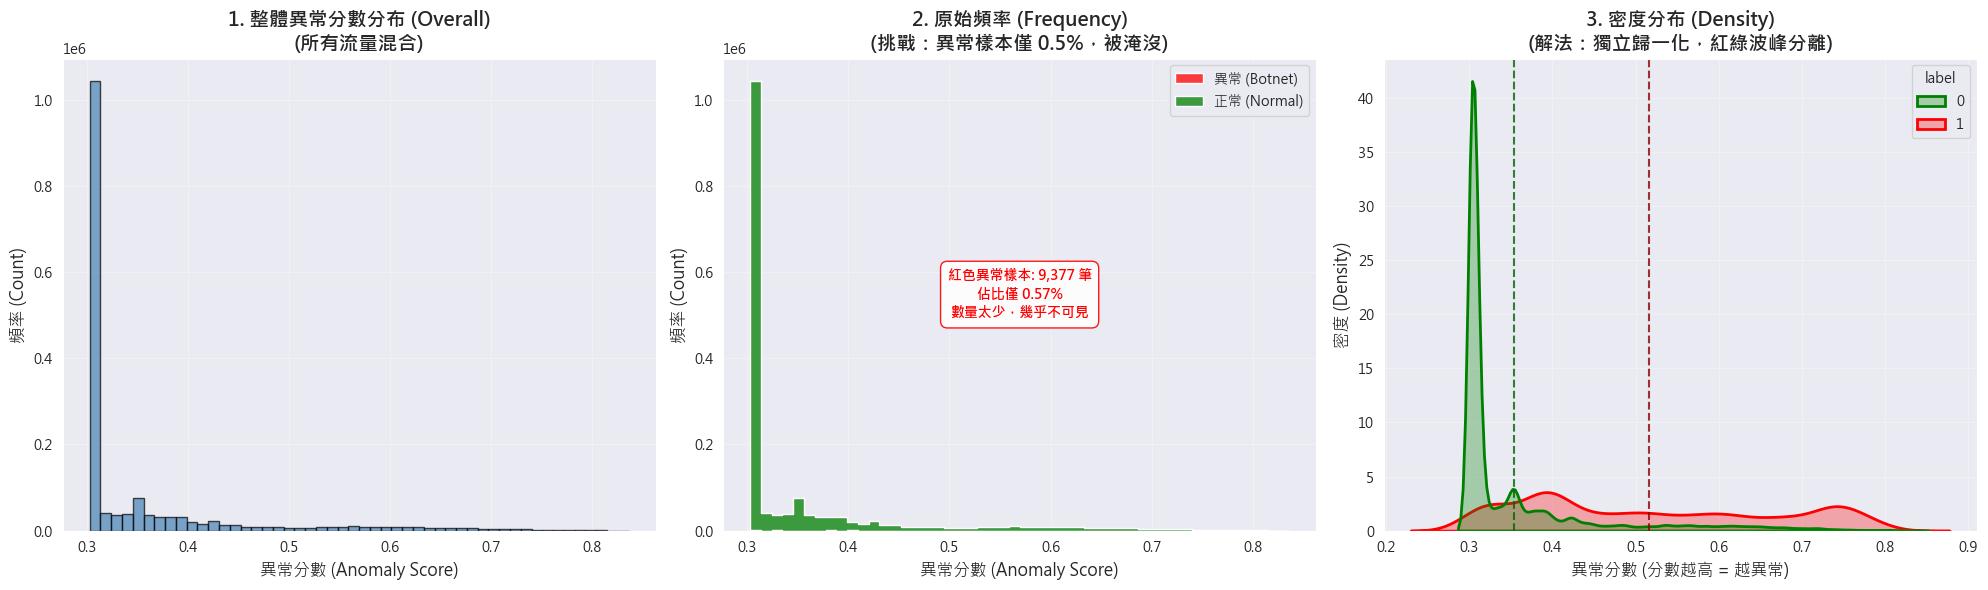

In [22]:
print("=" * 60)
print("📊 三張圖：基於原始標籤的分佈分析")
print("=" * 60)

# 設定畫布大小 (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- 圖 1: 整體分布 (Raw Score Distribution) ---
# 目的：展示模型輸出的原始樣貌
ax1 = axes[0]
ax1.hist(anomaly_scores_normalized, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_title('1. 整體異常分數分布 (Overall)\n(所有流量混合)', fontsize=14, fontweight='bold')
ax1.set_xlabel('異常分數 (Anomaly Score)', fontsize=12)
ax1.set_ylabel('頻率 (Count)', fontsize=12)
ax1.grid(True, alpha=0.3)

# --- 圖 2: 按標籤頻率 (Frequency by Label) ---
# 目的：展示「資料不平衡」帶來的挑戰 (紅色幾乎看不見)
ax2 = axes[1]
sns.histplot(
    x=anomaly_scores_normalized, 
    hue=y, 
    multiple="stack", 
    bins=50,
    palette={0: 'green', 1: 'red'},
    element="step",
    ax=ax2
)
ax2.set_title('2. 原始頻率 (Frequency)\n(挑戰：異常樣本僅 0.5%，被淹沒)', fontsize=14, fontweight='bold')
ax2.set_xlabel('異常分數 (Anomaly Score)', fontsize=12)
ax2.set_ylabel('頻率 (Count)', fontsize=12)
ax2.legend(labels=['異常 (Botnet)', '正常 (Normal)'])
ax2.grid(True, alpha=0.3)

# 加上一個箭頭或文字框指出問題 (動態計算筆數版本)
anom_count = y.sum()
total_count = len(y)
anom_ratio = anom_count / total_count
    
# 建立動態文字
text_content = (
        f"紅色異常樣本: {anom_count:,} 筆\n"
        f"佔比僅 {anom_ratio:.2%}\n"
        f"數量太少，幾乎不可見"
    )
    
ax2.text(0.5, 0.5, text_content, 
             transform=ax2.transAxes, ha='center', va='center', color='red', fontweight='bold',
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5'))

# --- 圖 3: 密度分布 (Density / KDE) ---
# 目的：展示「解決方案」，透過歸一化比較分佈形狀
ax3 = axes[2]
sns.kdeplot(
    x=anomaly_scores_normalized, 
    hue=y, 
    fill=True, 
    common_norm=False,  # <--- 關鍵參數：獨立歸一化
    palette={0: 'green', 1: 'red'},
    alpha=0.3,
    linewidth=2,
    ax=ax3
)

# 加上平均線，強化數據佐證
mean_norm = anomaly_scores_normalized[y==0].mean()
mean_anom = anomaly_scores_normalized[y==1].mean()
ax3.axvline(mean_norm, color='darkgreen', linestyle='--', alpha=0.8)
ax3.axvline(mean_anom, color='darkred', linestyle='--', alpha=0.8)

ax3.set_title('3. 密度分布 (Density)\n(解法：獨立歸一化，紅綠波峰分離)', fontsize=14, fontweight='bold')
ax3.set_xlabel('異常分數 (分數越高 = 越異常)', fontsize=12)
ax3.set_ylabel('密度 (Density)', fontsize=12)
ax3.grid(True, alpha=0.3)

# 調整版面並儲存
plt.tight_layout()
output_path = DOC_DIR / 'isolation_forest_3_panels.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"✅ 三面板分析圖已儲存至: {output_path}")
plt.show()

### 4.2. 圖表 B - Isolation Forest 預測標籤分佈圖 + 混淆矩陣

🔍 Isolation Forest 預測分類

預測結果統計:
   預測為正常 (Normal): 1,640,972 筆 (99.43%)
   預測為異常 (Outlier): 9,361 筆 (0.57%)

📊 三張圖：基於預測標籤的分佈分析
✅ 基於預測標籤的三面板分析圖已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\isolation_forest_predicted_labels_3_panels.png


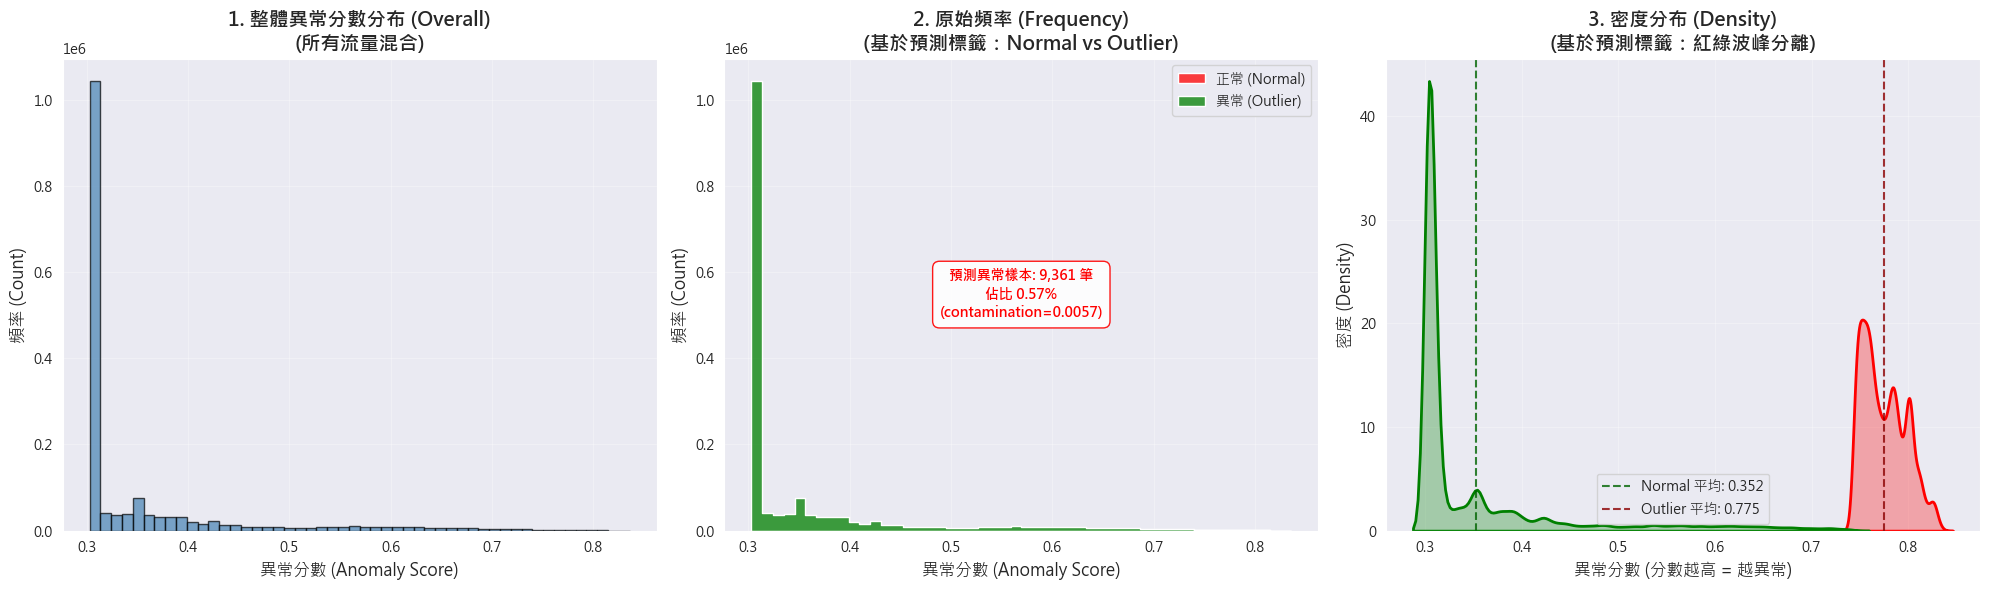


📊 混淆矩陣：預測 vs 真實標籤
✅ 混淆矩陣圖已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\isolation_forest_confusion_matrix.png


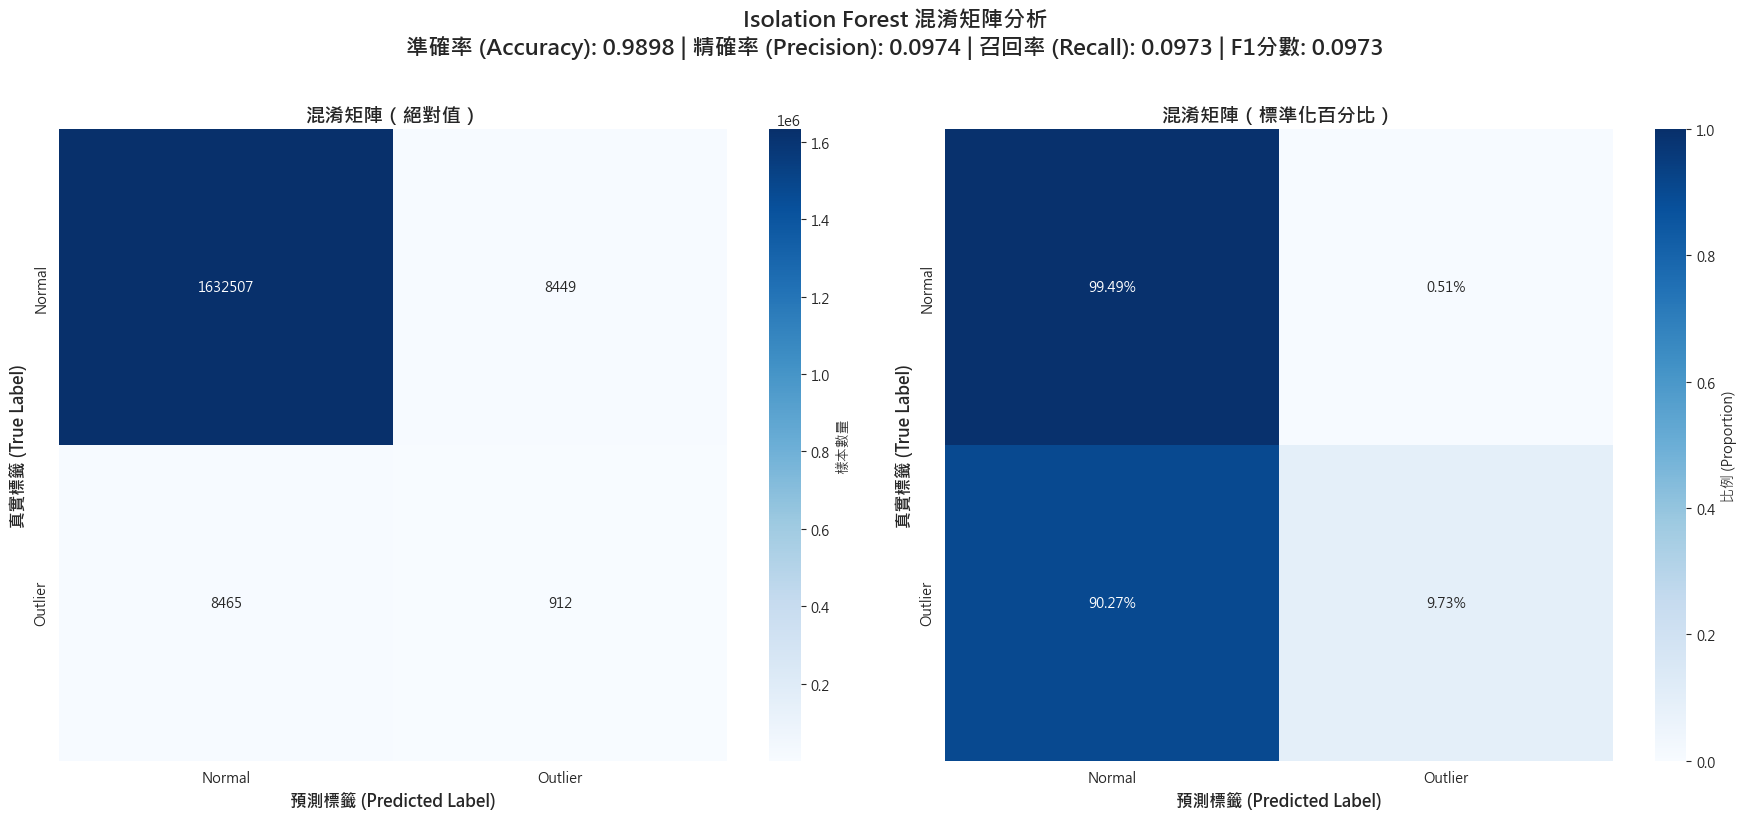


------------------------------------------------------------
分類報告 (Classification Report):
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99   1640956
     Outlier       0.10      0.10      0.10      9377

    accuracy                           0.99   1650333
   macro avg       0.55      0.55      0.55   1650333
weighted avg       0.99      0.99      0.99   1650333


------------------------------------------------------------
混淆矩陣詳細統計:
------------------------------------------------------------
真陰性 (True Negative, TN):  1,632,507 筆 - 正確預測為正常
假陽性 (False Positive, FP): 8,449 筆 - 誤判為異常（正常流量被標記為異常）
假陰性 (False Negative, FN): 8,465 筆 - 漏判（異常流量被標記為正常）
真陽性 (True Positive, TP):  912 筆 - 正確預測為異常

------------------------------------------------------------
標準化混淆矩陣解釋（按行歸一化）:
------------------------------------------------------------
真實為 Normal 的樣本中：
  - 99.49% 被正確預測為 Normal
  - 0.51%

In [23]:
# ============================================================
# 基於預測標籤的可視化 + 混淆矩陣
# ============================================================

# 步驟 1: 使用 predict() 方法進行分類
print("=" * 60)
print("🔍 Isolation Forest 預測分類")
print("=" * 60)

outlier_predictions = iso_forest.predict(X_scaled)
# Isolation Forest 的 predict() 返回：-1 (異常) 或 1 (正常)
# 轉換為更直觀的標籤：0 (正常) 和 1 (異常)
outlier_labels = (outlier_predictions == -1).astype(int)

# 統計分類結果
print(f"\n預測結果統計:")
print(f"   預測為正常 (Normal): {(outlier_labels == 0).sum():,} 筆 ({(outlier_labels == 0).mean():.2%})")
print(f"   預測為異常 (Outlier): {(outlier_labels == 1).sum():,} 筆 ({(outlier_labels == 1).mean():.2%})")

# ============================================================
# 圖表組 1: 基於預測標籤的三張圖
# ============================================================
print("\n" + "=" * 60)
print("📊 三張圖：基於預測標籤的分佈分析")
print("=" * 60)

# 設定畫布大小 (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# --- 圖 1: 整體分布 (Raw Score Distribution) ---
# 目的：展示模型輸出的原始樣貌（與現有圖1相同，但這裡是為了對比）
ax1 = axes[0]
ax1.hist(anomaly_scores_normalized, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.set_title('1. 整體異常分數分布 (Overall)\n(所有流量混合)', fontsize=14, fontweight='bold')
ax1.set_xlabel('異常分數 (Anomaly Score)', fontsize=12)
ax1.set_ylabel('頻率 (Count)', fontsize=12)
ax1.grid(True, alpha=0.3)

# --- 圖 2: 按預測標籤頻率 (Frequency by Predicted Label) ---
# 目的：展示模型預測的分類結果分佈
ax2 = axes[1]
sns.histplot(
    x=anomaly_scores_normalized, 
    hue=outlier_labels, 
    multiple="stack", 
    bins=50,
    palette={0: 'green', 1: 'red'},
    element="step",
    ax=ax2
)
ax2.set_title('2. 原始頻率 (Frequency)\n(基於預測標籤：Normal vs Outlier)', fontsize=14, fontweight='bold')
ax2.set_xlabel('異常分數 (Anomaly Score)', fontsize=12)
ax2.set_ylabel('頻率 (Count)', fontsize=12)
ax2.legend(labels=['正常 (Normal)', '異常 (Outlier)'])
ax2.grid(True, alpha=0.3)

# 加上統計資訊
pred_normal_count = (outlier_labels == 0).sum()
pred_outlier_count = (outlier_labels == 1).sum()
pred_outlier_ratio = pred_outlier_count / len(outlier_labels)

text_content = (
    f"預測異常樣本: {pred_outlier_count:,} 筆\n"
    f"佔比 {pred_outlier_ratio:.2%}\n"
    f"(contamination={contamination:.4f})"
)

ax2.text(0.5, 0.5, text_content, 
         transform=ax2.transAxes, ha='center', va='center', 
         color='red', fontweight='bold',
         bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5'))

# --- 圖 3: 密度分布 (Density / KDE) ---
# 目的：展示預測標籤的分佈形狀（獨立歸一化）
ax3 = axes[2]
sns.kdeplot(
    x=anomaly_scores_normalized, 
    hue=outlier_labels, 
    fill=True, 
    common_norm=False,  # <--- 關鍵參數：獨立歸一化
    palette={0: 'green', 1: 'red'},
    alpha=0.3,
    linewidth=2,
    ax=ax3
)

# 加上平均線，強化數據佐證
mean_pred_normal = anomaly_scores_normalized[outlier_labels == 0].mean()
mean_pred_outlier = anomaly_scores_normalized[outlier_labels == 1].mean()
ax3.axvline(mean_pred_normal, color='darkgreen', linestyle='--', alpha=0.8, 
            label=f'Normal 平均: {mean_pred_normal:.3f}')
ax3.axvline(mean_pred_outlier, color='darkred', linestyle='--', alpha=0.8,
            label=f'Outlier 平均: {mean_pred_outlier:.3f}')

ax3.set_title('3. 密度分布 (Density)\n(基於預測標籤：紅綠波峰分離)', fontsize=14, fontweight='bold')
ax3.set_xlabel('異常分數 (分數越高 = 越異常)', fontsize=12)
ax3.set_ylabel('密度 (Density)', fontsize=12)
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# 調整版面並儲存
plt.tight_layout()
output_path_1 = DOC_DIR / 'isolation_forest_predicted_labels_3_panels.png'
plt.savefig(output_path_1, dpi=300, bbox_inches='tight')
print(f"✅ 基於預測標籤的三面板分析圖已儲存至: {output_path_1}")
plt.show()

# ============================================================
# 圖表組 2: 混淆矩陣（單獨一張圖）- 改進版
# ============================================================
if y is not None:
    print("\n" + "=" * 60)
    print("📊 混淆矩陣：預測 vs 真實標籤")
    print("=" * 60)
    
    from sklearn.metrics import confusion_matrix, classification_report
    
    # 計算混淆矩陣
    cm = confusion_matrix(y, outlier_labels)
    
    # 計算標準化混淆矩陣（按行歸一化，顯示每個真實類別中被預測為各類的比例）
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 創建單獨的混淆矩陣圖（並排顯示：絕對值 + 百分比）
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # --- 左圖：絕對值混淆矩陣 ---
    ax1 = axes[0]
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        ax=ax1,
        xticklabels=['Normal', 'Outlier'],
        yticklabels=['Normal', 'Outlier'],
        cbar_kws={'label': '樣本數量'}
    )
    ax1.set_title('混淆矩陣（絕對值）', fontsize=14, fontweight='bold')
    ax1.set_xlabel('預測標籤 (Predicted Label)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('真實標籤 (True Label)', fontsize=12, fontweight='bold')
    
    # --- 右圖：標準化混淆矩陣（百分比）---
    ax2 = axes[1]
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt='.2%',  # 顯示為百分比
        cmap='Blues', 
        ax=ax2,
        xticklabels=['Normal', 'Outlier'],
        yticklabels=['Normal', 'Outlier'],
        cbar_kws={'label': '比例 (Proportion)'},
        vmin=0,  # 固定最小值為 0
        vmax=1   # 固定最大值為 1，確保顏色範圍一致
    )
    ax2.set_title('混淆矩陣（標準化百分比）', fontsize=14, fontweight='bold')
    ax2.set_xlabel('預測標籤 (Predicted Label)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('真實標籤 (True Label)', fontsize=12, fontweight='bold')
    
    # 計算指標
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # 在圖上方添加整體標題和指標
    fig.suptitle(
        f'Isolation Forest 混淆矩陣分析\n'
        f'準確率 (Accuracy): {accuracy:.4f} | '
        f'精確率 (Precision): {precision:.4f} | '
        f'召回率 (Recall): {recall:.4f} | '
        f'F1分數: {f1:.4f}',
        fontsize=16, 
        fontweight='bold',
        y=1.02
    )
    
    plt.tight_layout()
    output_path_2 = DOC_DIR / 'isolation_forest_confusion_matrix.png'
    plt.savefig(output_path_2, dpi=300, bbox_inches='tight')
    print(f"✅ 混淆矩陣圖已儲存至: {output_path_2}")
    plt.show()
    
    # 輸出詳細的分類報告
    print("\n" + "-" * 60)
    print("分類報告 (Classification Report):")
    print("-" * 60)
    print(classification_report(y, outlier_labels, target_names=['Normal', 'Outlier']))
    
    print("\n" + "-" * 60)
    print("混淆矩陣詳細統計:")
    print("-" * 60)
    print(f"真陰性 (True Negative, TN):  {tn:,} 筆 - 正確預測為正常")
    print(f"假陽性 (False Positive, FP): {fp:,} 筆 - 誤判為異常（正常流量被標記為異常）")
    print(f"假陰性 (False Negative, FN): {fn:,} 筆 - 漏判（異常流量被標記為正常）")
    print(f"真陽性 (True Positive, TP):  {tp:,} 筆 - 正確預測為異常")
    
    # 輸出標準化混淆矩陣的解釋
    print("\n" + "-" * 60)
    print("標準化混淆矩陣解釋（按行歸一化）:")
    print("-" * 60)
    print(f"真實為 Normal 的樣本中：")
    print(f"  - {cm_normalized[0,0]:.2%} 被正確預測為 Normal")
    print(f"  - {cm_normalized[0,1]:.2%} 被誤判為 Outlier")
    print(f"真實為 Outlier 的樣本中：")
    print(f"  - {cm_normalized[1,0]:.2%} 被漏判為 Normal")
    print(f"  - {cm_normalized[1,1]:.2%} 被正確預測為 Outlier")
    
else:
    print("\n⚠️  無法生成混淆矩陣：缺少真實標籤 (y)")

## 5. XGBoost (監督學習)


In [24]:
print("=" * 60)
print("XGBoost (監督學習)")
print("=" * 60)

if y is None:
    print("❌ 無法進行監督學習：缺少標籤資料")
else:
    # 分割訓練集和測試集
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\n資料分割:")
    print(f"   訓練集: {len(X_train):,} 筆 (異常: {y_train.sum():,})")
    print(f"   測試集: {len(X_test):,} 筆 (異常: {y_test.sum():,})")
    
    # 訓練 XGBoost（使用預設參數）
    print("\n訓練 XGBoost...")
    xgb_model = xgb.XGBClassifier(
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    print("✅ XGBoost 訓練完成")
    
    # 評估模型
    train_score = xgb_model.score(X_train, y_train)
    test_score = xgb_model.score(X_test, y_test)
    print(f"\n模型準確率:")
    print(f"   訓練集: {train_score:.4f}")
    print(f"   測試集: {test_score:.4f}")


XGBoost (監督學習)

資料分割:
   訓練集: 1,320,266 筆 (異常: 7,502)
   測試集: 330,067 筆 (異常: 1,875)

訓練 XGBoost...
✅ XGBoost 訓練完成

模型準確率:
   訓練集: 0.9968
   測試集: 0.9965


## 6. XGBoost 圖表


### 6.1 圖表 A - XGBoost 特徵重要性

圖表: XGBoost 特徵重要性

特徵重要性排序:
           feature  importance
       total_bytes    0.668120
      max_duration    0.083958
      avg_duration    0.077611
    bytes_per_flow    0.044812
        flow_count    0.038384
      min_duration    0.028853
dst_port_diversity    0.018748
  dst_ip_diversity    0.012815
protocol_diversity    0.010622
      port_entropy    0.007496
  packets_per_flow    0.004273
     total_packets    0.003942
  protocol_entropy    0.000366
✅ 圖表已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\xgboost_feature_importance.png


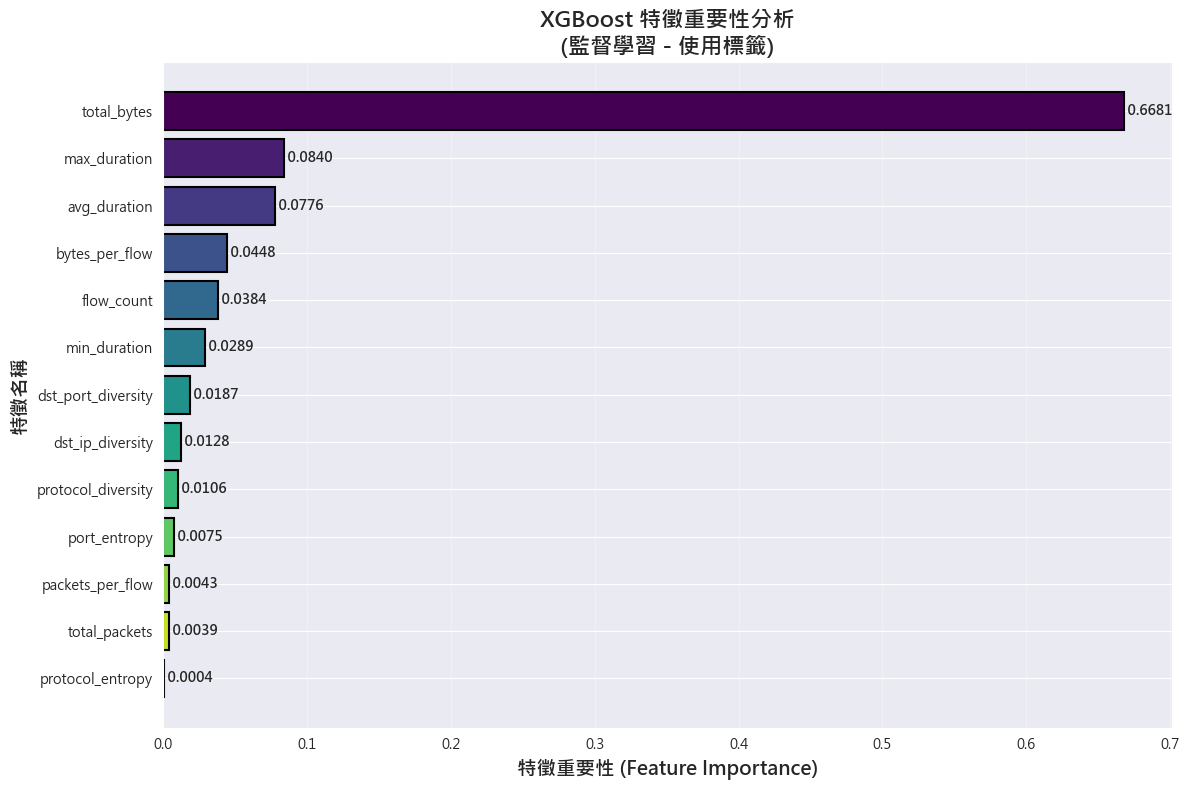


📊 重要特徵：
模型顯示以下特徵是區分 Botnet 的關鍵：
  • total_bytes: 0.6681
  • max_duration: 0.0840
  • avg_duration: 0.0776


In [25]:
print("=" * 60)
print("圖表: XGBoost 特徵重要性")
print("=" * 60)

if y is None:
    print("❌ 無法產生特徵重要性圖：缺少標籤資料")
else:
    # 取得特徵重要性
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\n特徵重要性排序:")
    print(feature_importance.to_string(index=False))
    
    # 建立圖表
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance)))
    bars = plt.barh(range(len(feature_importance)), 
                    feature_importance['importance'], 
                    color=colors, edgecolor='black', linewidth=1.5)
    
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('特徵重要性 (Feature Importance)', fontsize=14, fontweight='bold')
    plt.ylabel('特徵名稱', fontsize=14, fontweight='bold')
    plt.title('XGBoost 特徵重要性分析\n(監督學習 - 使用標籤)', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()  # 最重要的特徵在頂部
    
    # 添加數值標籤
    for i, (idx, row) in enumerate(feature_importance.iterrows()):
        plt.text(row['importance'], i, f" {row['importance']:.4f}", 
                va='center', fontsize=10, fontweight='bold')
    
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    output_path = DOC_DIR / 'xgboost_feature_importance.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 圖表已儲存至: {output_path}")
    plt.show()
    
    # 提出重要特徵
    print("\n" + "=" * 60)
    print("📊 重要特徵：")
    print("=" * 60)
    top_features = feature_importance.head(3)
    print("模型顯示以下特徵是區分 Botnet 的關鍵：")
    for idx, row in top_features.iterrows():
        print(f"  • {row['feature']}: {row['importance']:.4f}")
    print("=" * 60)


### 6.2 圖表 B - XGBoost 混淆矩陣

📊 圖表: XGBoost 混淆矩陣
✅ 混淆矩陣圖已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\xgboost_confusion_matrix.png


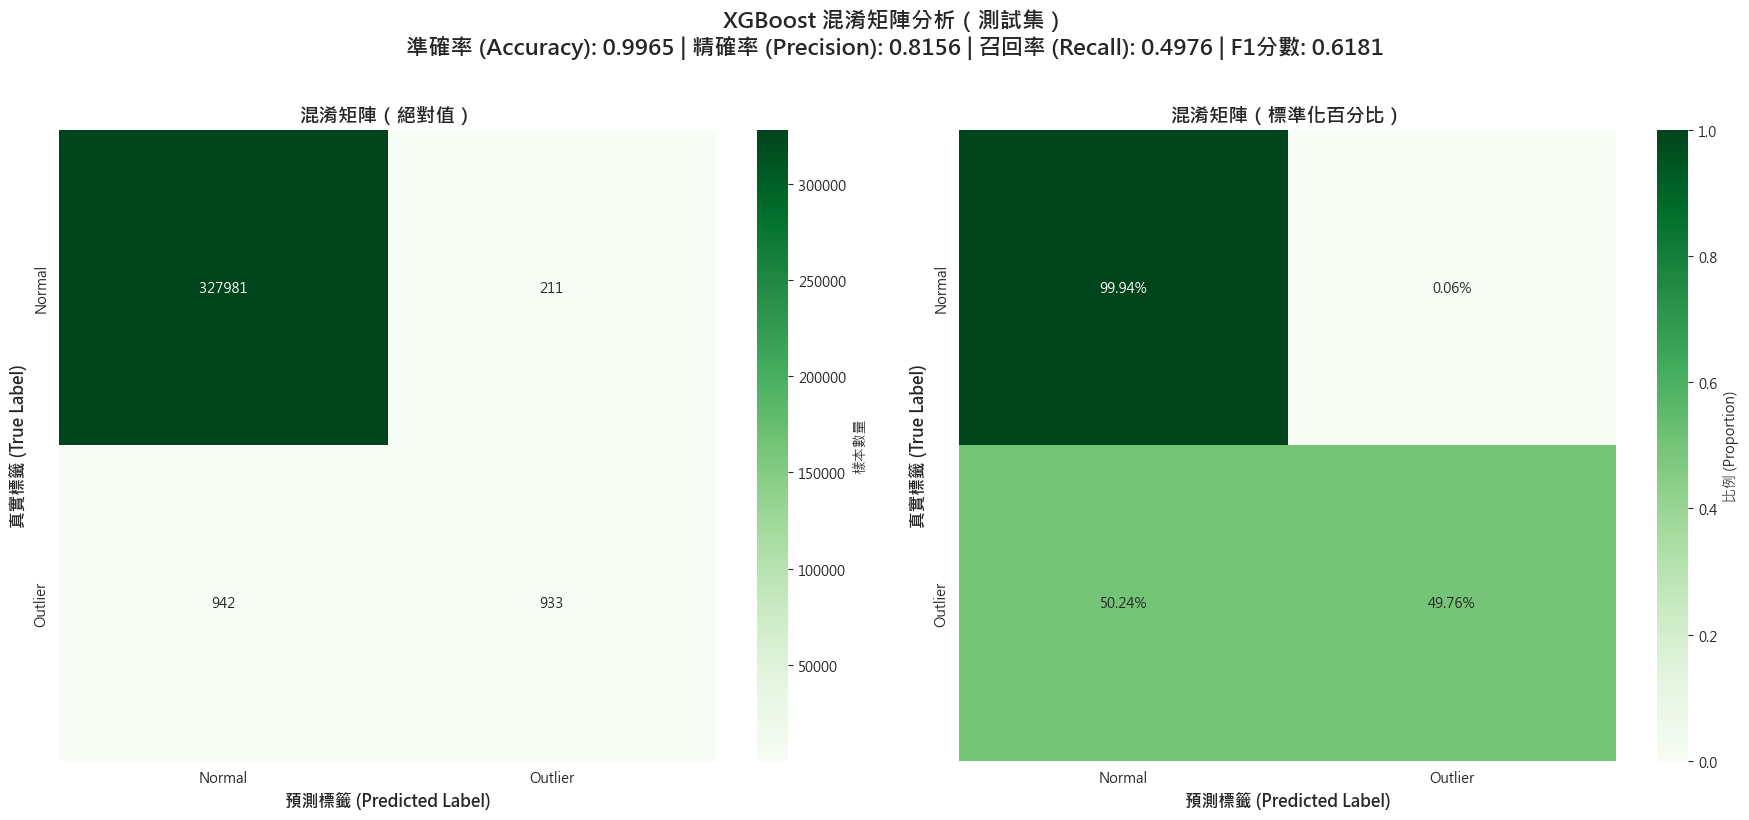


------------------------------------------------------------
分類報告 (Classification Report) - 測試集:
------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00    328192
     Outlier       0.82      0.50      0.62      1875

    accuracy                           1.00    330067
   macro avg       0.91      0.75      0.81    330067
weighted avg       1.00      1.00      1.00    330067


------------------------------------------------------------
混淆矩陣詳細統計:
------------------------------------------------------------
真陰性 (True Negative, TN):  327,981 筆 - 正確預測為正常
假陽性 (False Positive, FP): 211 筆 - 誤判為異常（正常流量被標記為異常）
假陰性 (False Negative, FN): 942 筆 - 漏判（異常流量被標記為正常）
真陽性 (True Positive, TP):  933 筆 - 正確預測為異常

------------------------------------------------------------
標準化混淆矩陣解釋（按行歸一化）:
------------------------------------------------------------
真實為 Normal 的樣本中：
  - 99.94% 被正確預測為 Normal
  - 0.06%

In [26]:
# ============================================================
# XGBoost 混淆矩陣
# ============================================================
print("=" * 60)
print("📊 圖表: XGBoost 混淆矩陣")
print("=" * 60)

if y is None:
    print("❌ 無法產生混淆矩陣：缺少標籤資料")
else:
    from sklearn.metrics import confusion_matrix, classification_report
    
    # 在測試集上進行預測
    y_test_pred = xgb_model.predict(X_test)
    
    # 計算混淆矩陣
    cm = confusion_matrix(y_test, y_test_pred)
    
    # 計算標準化混淆矩陣（按行歸一化）
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # 創建並排顯示的混淆矩陣圖
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # --- 左圖：絕對值混淆矩陣 ---
    ax1 = axes[0]
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Greens',  # 使用綠色系，與 Isolation Forest 的藍色系區分
        ax=ax1,
        xticklabels=['Normal', 'Outlier'],
        yticklabels=['Normal', 'Outlier'],
        cbar_kws={'label': '樣本數量'}
    )
    ax1.set_title('混淆矩陣（絕對值）', fontsize=14, fontweight='bold')
    ax1.set_xlabel('預測標籤 (Predicted Label)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('真實標籤 (True Label)', fontsize=12, fontweight='bold')
    
    # --- 右圖：標準化混淆矩陣（百分比）---
    ax2 = axes[1]
    sns.heatmap(
        cm_normalized, 
        annot=True, 
        fmt='.2%',  # 顯示為百分比
        cmap='Greens', 
        ax=ax2,
        xticklabels=['Normal', 'Outlier'],
        yticklabels=['Normal', 'Outlier'],
        cbar_kws={'label': '比例 (Proportion)'},
        vmin=0,  # 固定最小值為 0
        vmax=1   # 固定最大值為 1，確保顏色範圍一致
    )
    ax2.set_title('混淆矩陣（標準化百分比）', fontsize=14, fontweight='bold')
    ax2.set_xlabel('預測標籤 (Predicted Label)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('真實標籤 (True Label)', fontsize=12, fontweight='bold')
    
    # 計算指標
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # 在圖上方添加整體標題和指標
    fig.suptitle(
        f'XGBoost 混淆矩陣分析（測試集）\n'
        f'準確率 (Accuracy): {accuracy:.4f} | '
        f'精確率 (Precision): {precision:.4f} | '
        f'召回率 (Recall): {recall:.4f} | '
        f'F1分數: {f1:.4f}',
        fontsize=16, 
        fontweight='bold',
        y=1.02
    )
    
    plt.tight_layout()
    output_path = DOC_DIR / 'xgboost_confusion_matrix.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 混淆矩陣圖已儲存至: {output_path}")
    plt.show()
    
    # 輸出詳細的分類報告
    print("\n" + "-" * 60)
    print("分類報告 (Classification Report) - 測試集:")
    print("-" * 60)
    print(classification_report(y_test, y_test_pred, target_names=['Normal', 'Outlier']))
    
    print("\n" + "-" * 60)
    print("混淆矩陣詳細統計:")
    print("-" * 60)
    print(f"真陰性 (True Negative, TN):  {tn:,} 筆 - 正確預測為正常")
    print(f"假陽性 (False Positive, FP): {fp:,} 筆 - 誤判為異常（正常流量被標記為異常）")
    print(f"假陰性 (False Negative, FN): {fn:,} 筆 - 漏判（異常流量被標記為正常）")
    print(f"真陽性 (True Positive, TP):  {tp:,} 筆 - 正確預測為異常")
    
    # 輸出標準化混淆矩陣的解釋
    print("\n" + "-" * 60)
    print("標準化混淆矩陣解釋（按行歸一化）:")
    print("-" * 60)
    print(f"真實為 Normal 的樣本中：")
    print(f"  - {cm_normalized[0,0]:.2%} 被正確預測為 Normal")
    print(f"  - {cm_normalized[0,1]:.2%} 被誤判為 Outlier")
    print(f"真實為 Outlier 的樣本中：")
    print(f"  - {cm_normalized[1,0]:.2%} 被漏判為 Normal")
    print(f"  - {cm_normalized[1,1]:.2%} 被正確預測為 Outlier")

### 6.3. 圖表 C - XGBoost ROC 曲線與 Precision-Recall 曲線

📊 圖表: XGBoost ROC 曲線與 Precision-Recall 曲線
✅ ROC/PR 曲線圖已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\xgboost_roc_pr_curves.png


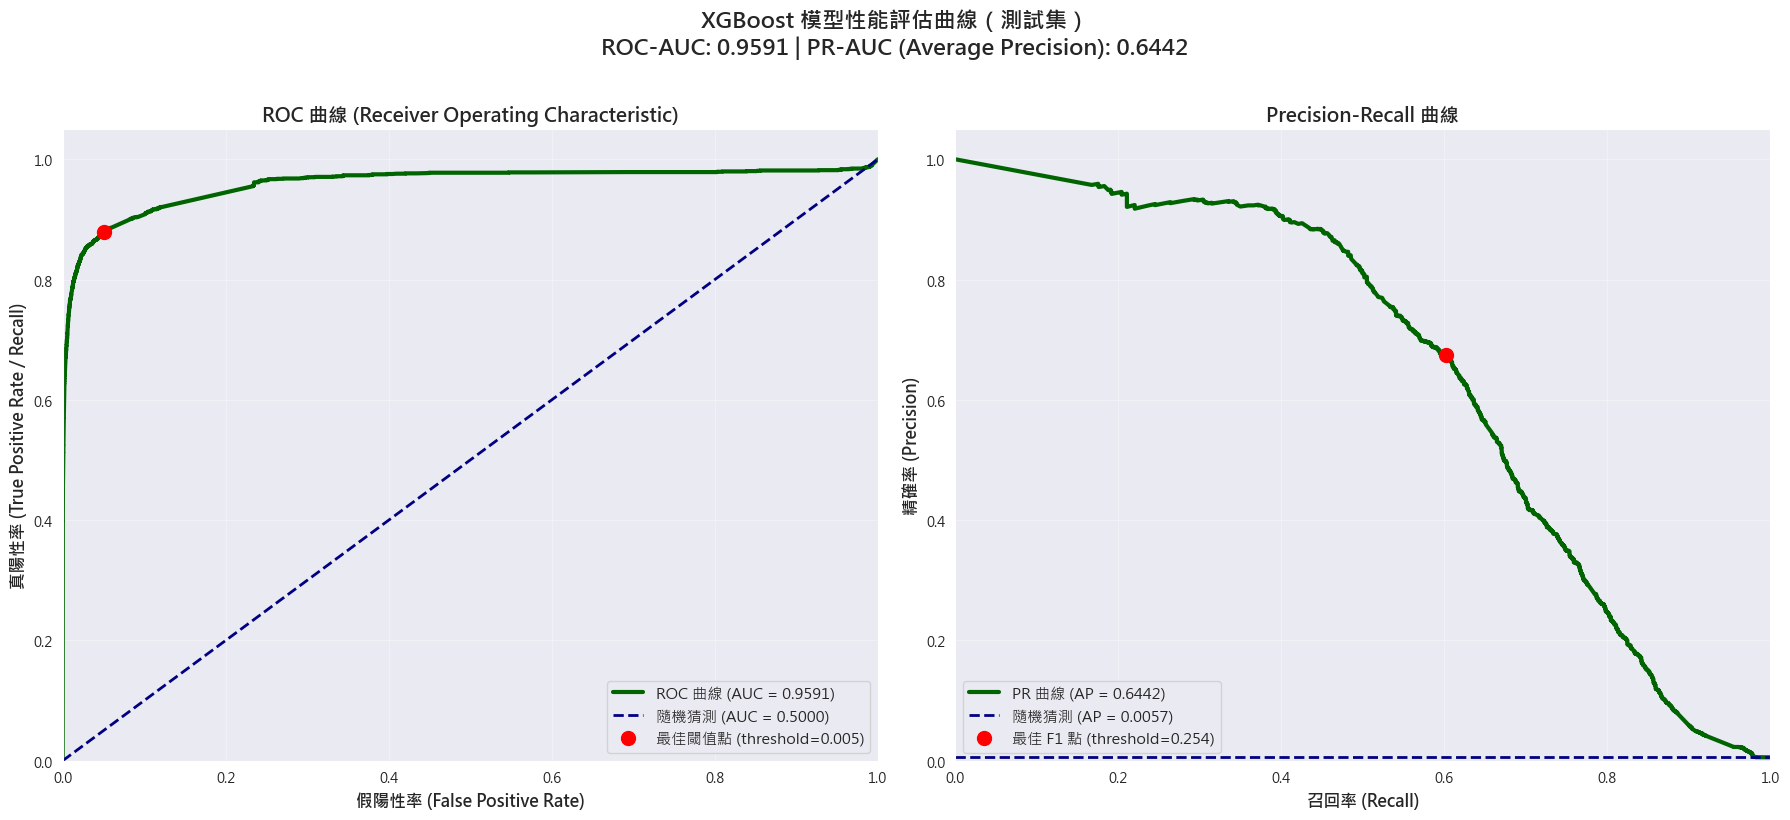


------------------------------------------------------------
ROC 曲線統計:
------------------------------------------------------------
ROC-AUC 分數: 0.9591
  解釋: 模型區分正常與異常流量的整體能力
  範圍: 0.5 (隨機) ~ 1.0 (完美)
  評估: 優秀

------------------------------------------------------------
Precision-Recall 曲線統計:
------------------------------------------------------------
PR-AUC (Average Precision) 分數: 0.6442
  解釋: 在異常檢測任務中的精確率-召回率平衡
  範圍: 0.0 (最差) ~ 1.0 (完美)
  評估: 良好
  注意: 對於不平衡數據集，PR 曲線比 ROC 曲線更敏感

最佳閾值建議:
  ROC 最佳閾值 (Youden's J): 0.0047
  PR 最佳閾值 (F1 最大化): 0.2541


In [27]:
# ============================================================
# XGBoost ROC 曲線與 Precision-Recall 曲線
# ============================================================
print("=" * 60)
print("📊 圖表: XGBoost ROC 曲線與 Precision-Recall 曲線")
print("=" * 60)

if y is None:
    print("❌ 無法產生 ROC/PR 曲線：缺少標籤資料")
else:
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
    
    # 獲取預測概率（對於異常類別，即 label=1）
    y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
    
    # 計算 ROC 曲線
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_proba)
    roc_auc = auc(fpr, tpr)
    
    # 計算 Precision-Recall 曲線
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_proba)
    pr_auc = average_precision_score(y_test, y_test_proba)
    
    # 創建並排顯示的圖表
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # --- 左圖：ROC 曲線 ---
    ax1 = axes[0]
    ax1.plot(fpr, tpr, color='darkgreen', lw=3, 
             label=f'ROC 曲線 (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='隨機猜測 (AUC = 0.5000)')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('假陽性率 (False Positive Rate)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('真陽性率 (True Positive Rate / Recall)', fontsize=12, fontweight='bold')
    ax1.set_title('ROC 曲線 (Receiver Operating Characteristic)', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc="lower right", fontsize=11)
    ax1.grid(True, alpha=0.3)
    
    # 標註最佳閾值點（最接近左上角的點）
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = roc_thresholds[optimal_idx]
    ax1.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10, 
             label=f'最佳閾值點 (threshold={optimal_threshold:.3f})')
    ax1.legend(loc="lower right", fontsize=11)
    
    # --- 右圖：Precision-Recall 曲線 ---
    ax2 = axes[1]
    ax2.plot(recall, precision, color='darkgreen', lw=3,
             label=f'PR 曲線 (AP = {pr_auc:.4f})')
    
    # 計算隨機猜測的 baseline（對於不平衡數據集）
    baseline = len(y_test[y_test == 1]) / len(y_test)
    ax2.axhline(y=baseline, color='navy', lw=2, linestyle='--',
                label=f'隨機猜測 (AP = {baseline:.4f})')
    
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('召回率 (Recall)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('精確率 (Precision)', fontsize=12, fontweight='bold')
    ax2.set_title('Precision-Recall 曲線', fontsize=14, fontweight='bold')
    ax2.legend(loc="lower left", fontsize=11)
    ax2.grid(True, alpha=0.3)
    
    # 標註最佳閾值點（F1 分數最高的點）
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_pr_idx = np.argmax(f1_scores)
    optimal_pr_threshold = pr_thresholds[optimal_pr_idx] if optimal_pr_idx < len(pr_thresholds) else 0.5
    ax2.plot(recall[optimal_pr_idx], precision[optimal_pr_idx], 'ro', markersize=10,
             label=f'最佳 F1 點 (threshold={optimal_pr_threshold:.3f})')
    ax2.legend(loc="lower left", fontsize=11)
    
    # 在圖上方添加整體標題
    fig.suptitle(
        f'XGBoost 模型性能評估曲線（測試集）\n'
        f'ROC-AUC: {roc_auc:.4f} | PR-AUC (Average Precision): {pr_auc:.4f}',
        fontsize=16, 
        fontweight='bold',
        y=1.02
    )
    
    plt.tight_layout()
    output_path = DOC_DIR / 'xgboost_roc_pr_curves.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ ROC/PR 曲線圖已儲存至: {output_path}")
    plt.show()
    
    # 輸出詳細統計
    print("\n" + "-" * 60)
    print("ROC 曲線統計:")
    print("-" * 60)
    print(f"ROC-AUC 分數: {roc_auc:.4f}")
    print(f"  解釋: 模型區分正常與異常流量的整體能力")
    print(f"  範圍: 0.5 (隨機) ~ 1.0 (完美)")
    print(f"  評估: {'優秀' if roc_auc > 0.9 else '良好' if roc_auc > 0.8 else '一般'}")
    
    print("\n" + "-" * 60)
    print("Precision-Recall 曲線統計:")
    print("-" * 60)
    print(f"PR-AUC (Average Precision) 分數: {pr_auc:.4f}")
    print(f"  解釋: 在異常檢測任務中的精確率-召回率平衡")
    print(f"  範圍: 0.0 (最差) ~ 1.0 (完美)")
    print(f"  評估: {'優秀' if pr_auc > 0.8 else '良好' if pr_auc > 0.6 else '一般'}")
    print(f"  注意: 對於不平衡數據集，PR 曲線比 ROC 曲線更敏感")
    
    print(f"\n最佳閾值建議:")
    print(f"  ROC 最佳閾值 (Youden's J): {optimal_threshold:.4f}")
    print(f"  PR 最佳閾值 (F1 最大化): {optimal_pr_threshold:.4f}")

### 6.4. 圖表 D - XGBoost 預測概率分佈圖

📊 圖表: XGBoost 預測概率分佈圖

預測概率統計（測試集）:
   概率範圍: [0.0000, 1.0000]
   平均概率: 0.0056
   中位數概率: 0.0001

預測概率統計（按真實標籤）:
   正常流量 (label=0): 平均概率 = 0.0028
   異常流量 (label=1): 平均概率 = 0.4963
✅ 預測概率分佈圖已儲存至: C:\MyVS\NetworkAnomalyDetection\doc\xgboost_prediction_probability_distribution.png


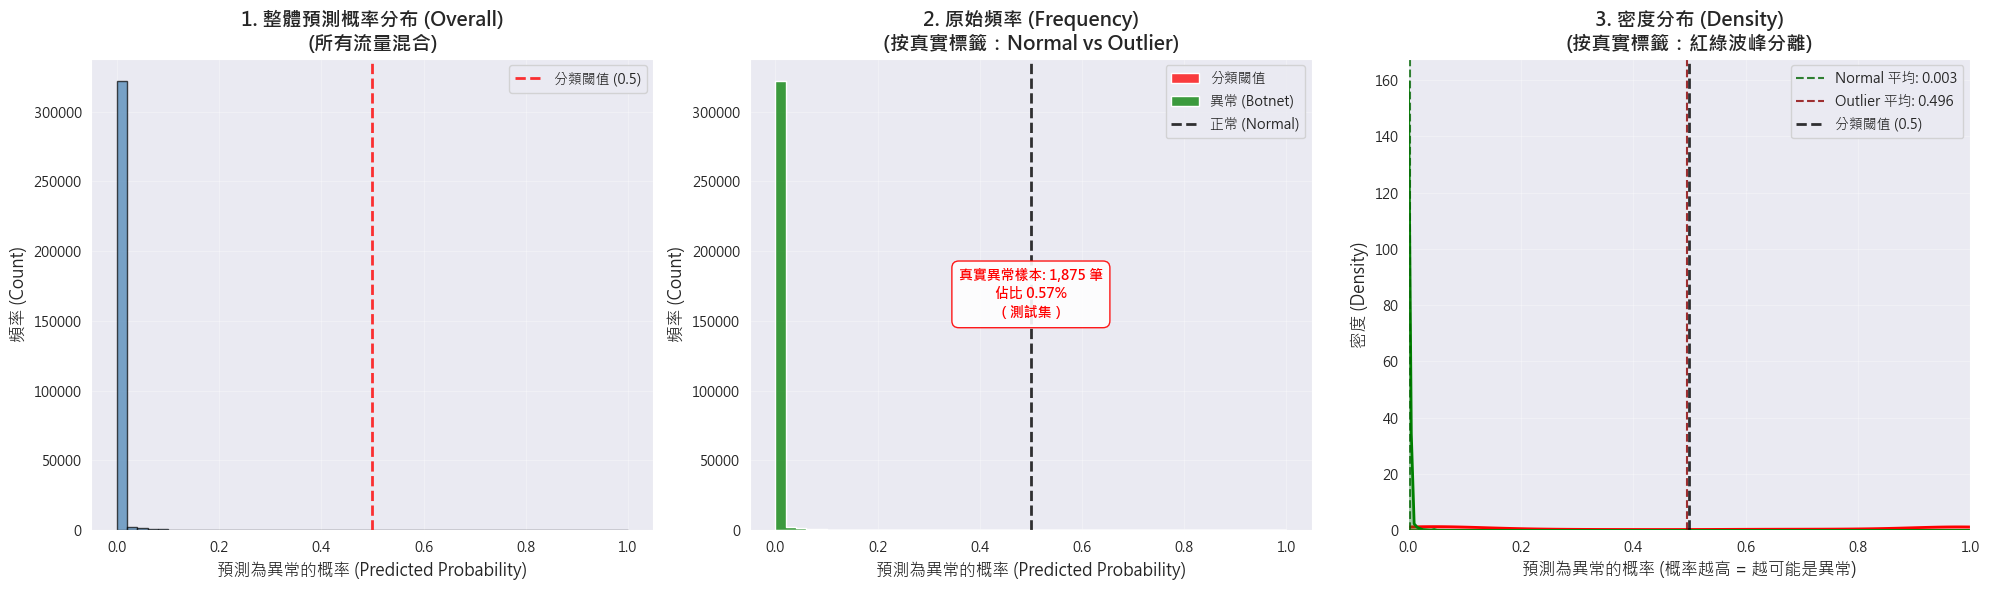


------------------------------------------------------------
預測概率分佈分析:
------------------------------------------------------------

按概率區間分佈（所有樣本）:
  非常低 (0.0-0.1): 327,127 筆 (99.11%)
  低 (0.1-0.3): 1,377 筆 (0.42%)
  中等偏低 (0.3-0.5): 419 筆 (0.13%)
  中等偏高 (0.5-0.7): 325 筆 (0.10%)
  高 (0.7-0.9): 229 筆 (0.07%)
  非常高 (0.9-1.0): 262 筆 (0.08%)

按概率區間分佈（僅異常樣本）:
  非常低 (0.0-0.1): 570 筆 (30.40%)
  低 (0.1-0.3): 218 筆 (11.63%)
  中等偏低 (0.3-0.5): 154 筆 (8.21%)
  中等偏高 (0.5-0.7): 189 筆 (10.08%)
  高 (0.7-0.9): 194 筆 (10.35%)
  非常高 (0.9-1.0): 236 筆 (12.59%)

按概率區間分佈（僅正常樣本）:
  非常低 (0.0-0.1): 326,557 筆 (99.50%)
  低 (0.1-0.3): 1,159 筆 (0.35%)
  中等偏低 (0.3-0.5): 265 筆 (0.08%)
  中等偏高 (0.5-0.7): 136 筆 (0.04%)
  高 (0.7-0.9): 35 筆 (0.01%)
  非常高 (0.9-1.0): 26 筆 (0.01%)

------------------------------------------------------------
模型信心度分析:
------------------------------------------------------------
高信心度預測（正常樣本，概率 < 0.3）: 327,716 筆 (99.85%)
高信心度預測（異常樣本，概率 > 0.7）: 744 筆 (39.68%)
不確定預測（概率在 0.4-0.6 之間）: 401 筆 (0.12%)

In [28]:
# ============================================================
# XGBoost 預測概率分佈圖
# ============================================================
print("=" * 60)
print("📊 圖表: XGBoost 預測概率分佈圖")
print("=" * 60)

if y is None:
    print("❌ 無法產生預測概率分佈圖：缺少標籤資料")
else:
    # 獲取預測概率（對於異常類別，即 label=1）
    y_test_proba = xgb_model.predict_proba(X_test)[:, 1]
    y_test_pred = xgb_model.predict(X_test)
    
    # 統計預測概率
    print(f"\n預測概率統計（測試集）:")
    print(f"   概率範圍: [{y_test_proba.min():.4f}, {y_test_proba.max():.4f}]")
    print(f"   平均概率: {y_test_proba.mean():.4f}")
    print(f"   中位數概率: {np.median(y_test_proba):.4f}")
    
    if y_test is not None:
        print(f"\n預測概率統計（按真實標籤）:")
        print(f"   正常流量 (label=0): 平均概率 = {y_test_proba[y_test==0].mean():.4f}")
        print(f"   異常流量 (label=1): 平均概率 = {y_test_proba[y_test==1].mean():.4f}")
    
    # 設定畫布大小 (1 row, 3 columns)
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # --- 圖 1: 整體分布 (Overall Probability Distribution) ---
    # 目的：展示模型輸出的預測概率原始樣貌
    ax1 = axes[0]
    ax1.hist(y_test_proba, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    ax1.axvline(0.5, color='red', linestyle='--', linewidth=2, 
                label='分類閾值 (0.5)', alpha=0.8)
    ax1.set_title('1. 整體預測概率分布 (Overall)\n(所有流量混合)', 
                  fontsize=14, fontweight='bold')
    ax1.set_xlabel('預測為異常的概率 (Predicted Probability)', fontsize=12)
    ax1.set_ylabel('頻率 (Count)', fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # --- 圖 2: 按真實標籤頻率 (Frequency by True Label) ---
    # 目的：展示真實標籤與預測概率的關係
    ax2 = axes[1]
    sns.histplot(
        x=y_test_proba, 
        hue=y_test, 
        multiple="stack", 
        bins=50,
        palette={0: 'green', 1: 'red'},
        element="step",
        ax=ax2
    )
    ax2.axvline(0.5, color='black', linestyle='--', linewidth=2, 
                label='分類閾值 (0.5)', alpha=0.8)
    ax2.set_title('2. 原始頻率 (Frequency)\n(按真實標籤：Normal vs Outlier)', 
                  fontsize=14, fontweight='bold')
    ax2.set_xlabel('預測為異常的概率 (Predicted Probability)', fontsize=12)
    ax2.set_ylabel('頻率 (Count)', fontsize=12)
    ax2.legend(labels=['分類閾值', '異常 (Botnet)', '正常 (Normal)'], fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 加上統計資訊
    if y_test is not None:
        normal_count = (y_test == 0).sum()
        outlier_count = (y_test == 1).sum()
        outlier_ratio = outlier_count / len(y_test)
        
        text_content = (
            f"真實異常樣本: {outlier_count:,} 筆\n"
            f"佔比 {outlier_ratio:.2%}\n"
            f"（測試集）"
        )
        
        ax2.text(0.5, 0.5, text_content, 
                 transform=ax2.transAxes, ha='center', va='center', 
                 color='red', fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.9, edgecolor='red', boxstyle='round,pad=0.5'))
    
    # --- 圖 3: 密度分布 (Density / KDE) ---
    # 目的：展示預測概率的分佈形狀（獨立歸一化）
    ax3 = axes[2]
    if y_test is not None:
        sns.kdeplot(
            x=y_test_proba, 
            hue=y_test, 
            fill=True, 
            common_norm=False,  # <--- 關鍵參數：獨立歸一化
            palette={0: 'green', 1: 'red'},
            alpha=0.3,
            linewidth=2,
            ax=ax3
        )
        
        # 加上平均線，強化數據佐證
        mean_normal_prob = y_test_proba[y_test==0].mean()
        mean_outlier_prob = y_test_proba[y_test==1].mean()
        ax3.axvline(mean_normal_prob, color='darkgreen', linestyle='--', alpha=0.8, 
                    label=f'Normal 平均: {mean_normal_prob:.3f}')
        ax3.axvline(mean_outlier_prob, color='darkred', linestyle='--', alpha=0.8,
                    label=f'Outlier 平均: {mean_outlier_prob:.3f}')
        ax3.axvline(0.5, color='black', linestyle='--', linewidth=2, 
                    label='分類閾值 (0.5)', alpha=0.8)
    else:
        sns.kdeplot(
            x=y_test_proba, 
            fill=True, 
            color='steelblue',
            alpha=0.3,
            linewidth=2,
            ax=ax3
        )
        ax3.axvline(0.5, color='red', linestyle='--', linewidth=2, 
                    label='分類閾值 (0.5)', alpha=0.8)
    
    ax3.set_title('3. 密度分布 (Density)\n(按真實標籤：紅綠波峰分離)', 
                  fontsize=14, fontweight='bold')
    ax3.set_xlabel('預測為異常的概率 (概率越高 = 越可能是異常)', fontsize=12)
    ax3.set_ylabel('密度 (Density)', fontsize=12)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim([0, 1])
    
    # 調整版面並儲存
    plt.tight_layout()
    output_path = DOC_DIR / 'xgboost_prediction_probability_distribution.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"✅ 預測概率分佈圖已儲存至: {output_path}")
    plt.show()
    
    # 輸出詳細分析
    if y_test is not None:
        print("\n" + "-" * 60)
        print("預測概率分佈分析:")
        print("-" * 60)
        
        # 計算不同概率區間的分布
        prob_ranges = [
            (0.0, 0.1, "非常低 (0.0-0.1)"),
            (0.1, 0.3, "低 (0.1-0.3)"),
            (0.3, 0.5, "中等偏低 (0.3-0.5)"),
            (0.5, 0.7, "中等偏高 (0.5-0.7)"),
            (0.7, 0.9, "高 (0.7-0.9)"),
            (0.9, 1.0, "非常高 (0.9-1.0)")
        ]
        
        print("\n按概率區間分佈（所有樣本）:")
        for low, high, label in prob_ranges:
            count = ((y_test_proba >= low) & (y_test_proba < high)).sum()
            percentage = count / len(y_test_proba) * 100
            print(f"  {label}: {count:,} 筆 ({percentage:.2f}%)")
        
        print("\n按概率區間分佈（僅異常樣本）:")
        outlier_proba = y_test_proba[y_test == 1]
        for low, high, label in prob_ranges:
            count = ((outlier_proba >= low) & (outlier_proba < high)).sum()
            percentage = count / len(outlier_proba) * 100 if len(outlier_proba) > 0 else 0
            print(f"  {label}: {count:,} 筆 ({percentage:.2f}%)")
        
        print("\n按概率區間分佈（僅正常樣本）:")
        normal_proba = y_test_proba[y_test == 0]
        for low, high, label in prob_ranges:
            count = ((normal_proba >= low) & (normal_proba < high)).sum()
            percentage = count / len(normal_proba) * 100 if len(normal_proba) > 0 else 0
            print(f"  {label}: {count:,} 筆 ({percentage:.2f}%)")
        
        # 計算模型信心度
        print("\n" + "-" * 60)
        print("模型信心度分析:")
        print("-" * 60)
        high_confidence_normal = (y_test_proba[y_test == 0] < 0.3).sum()
        high_confidence_outlier = (y_test_proba[y_test == 1] > 0.7).sum()
        
        print(f"高信心度預測（正常樣本，概率 < 0.3）: {high_confidence_normal:,} 筆 "
              f"({high_confidence_normal/len(y_test[y_test==0])*100:.2f}%)")
        print(f"高信心度預測（異常樣本，概率 > 0.7）: {high_confidence_outlier:,} 筆 "
              f"({high_confidence_outlier/len(y_test[y_test==1])*100:.2f}%)")
        
        # 計算不確定的預測（接近閾值）
        uncertain = ((y_test_proba >= 0.4) & (y_test_proba <= 0.6)).sum()
        print(f"不確定預測（概率在 0.4-0.6 之間）: {uncertain:,} 筆 "
              f"({uncertain/len(y_test_proba)*100:.2f}%)")

## 7. 結論與比較

### Isolation Forest vs XGBoost

| 特性 | Isolation Forest | XGBoost |
|------|------------------|---------|
| **學習方式** | 無監督學習 | 監督學習 |
| **需要標籤** | ❌ 不需要 | ✅ 需要 |
| **適用場景** | 未知異常類型、標籤稀少 | 有明確標籤、需要解釋性 |
| **優勢** | 能發現未知異常模式 | 準確率高、可解釋性強 |
| **輸出** | 異常分數 | 分類結果 + 特徵重要性 |

### 實務建議

1. **初期探索階段**：使用 Isolation Forest 快速識別異常模式
2. **標籤充足後**：使用 XGBoost 獲得更高準確率和可解釋性
3. **混合策略**：結合兩種方法，Isolation Forest 用於發現新異常，XGBoost 用於已知異常分類
